# 1 Import libraries and load dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools
import warnings
warnings.filterwarnings("ignore")

In [68]:
df = pd.read_csv('Airline customers.csv')
df.head()

,Month,#Passengers
0,2008-01-01,4704
1,2008-02-01,4956
2,2008-03-01,5544
3,2008-04-01,5418
4,2008-05-01,5082


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


# 2 Data preprocessing

In [70]:
# Convert 'Month' to datetime and set it as index
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d', errors='coerce')
df.set_index('Month', inplace=True)
df.rename(columns={'#Passengers': 'MonthlyPassengers'}, inplace=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2008-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   MonthlyPassengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [72]:
df.isnull().sum()

MonthlyPassengers    0
dtype: int64

In [73]:
df.duplicated().sum()

26

There are no duplicates or missing values.

# 3 Exploratory Data Analysis

In [74]:
df.describe()

,MonthlyPassengers
count,144.000000
mean,11772.541667
std,5038.585312
min,4368.000000
25%,7560.000000
50%,11151.000000
75%,15141.000000
max,26124.000000


### Dynamics of target variable

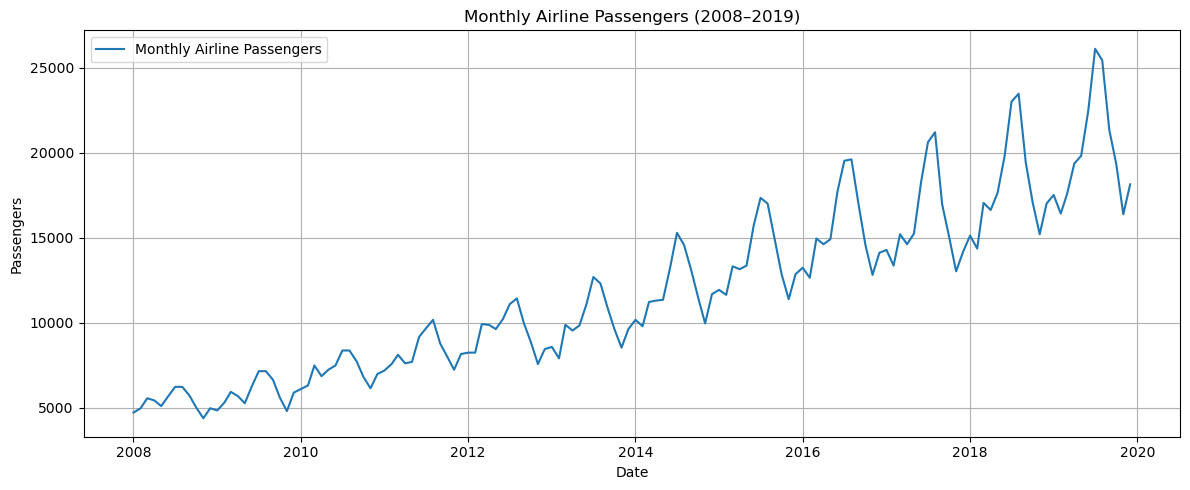

In [75]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['MonthlyPassengers'], label='Monthly Airline Passengers')
plt.title('Monthly Airline Passengers (2008–2019)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Check for trend, seasonality, and residuals in the  time series 

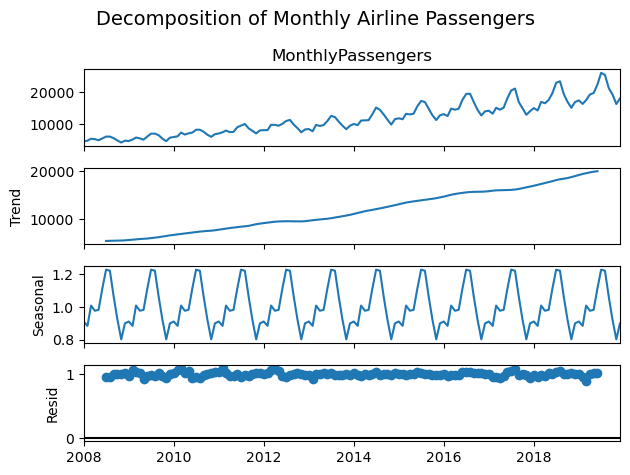

In [76]:
decomposition = seasonal_decompose(df['MonthlyPassengers'], model='multiplicative', period=12)
decomposition.plot()
plt.suptitle('Decomposition of Monthly Airline Passengers', fontsize=14)
plt.tight_layout()
plt.show()

- The decomposition reveals a well-defined trend and seasonal pattern, making this dataset highly suitable for models like SARIMA or Prophet.
- The residuals appear to be centered around zero with consistent variance. 
- Further modeling should account for both trend and seasonality to ensure accurate forecasting.

### Seasonal Patterns by Year and Month

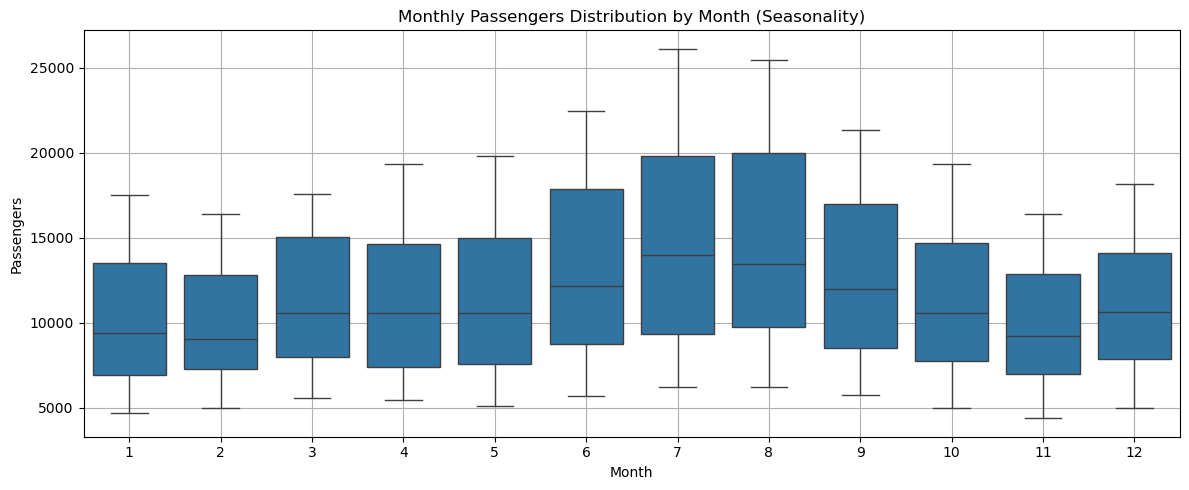

In [77]:
df['Year'] = df.index.year
df['Month'] = df.index.month

plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='Month', y='MonthlyPassengers')
plt.title("Monthly Passengers Distribution by Month (Seasonality)")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.grid(True)
plt.tight_layout()
plt.show()


- No extreme outliers are visibly marked, suggesting data is without significant anomalies for each month.
- Passenger numbers peak in July  and August — this aligns with the summer holiday season, where travel demand typically spikes. These months show both higher medians and greater variability, indicating a larger range of passenger volumes during peak seasons.
- February and November  have the lowest medians and narrower interquartile ranges. These months are likely part of the off-season for travel.

### Stationarity Check 

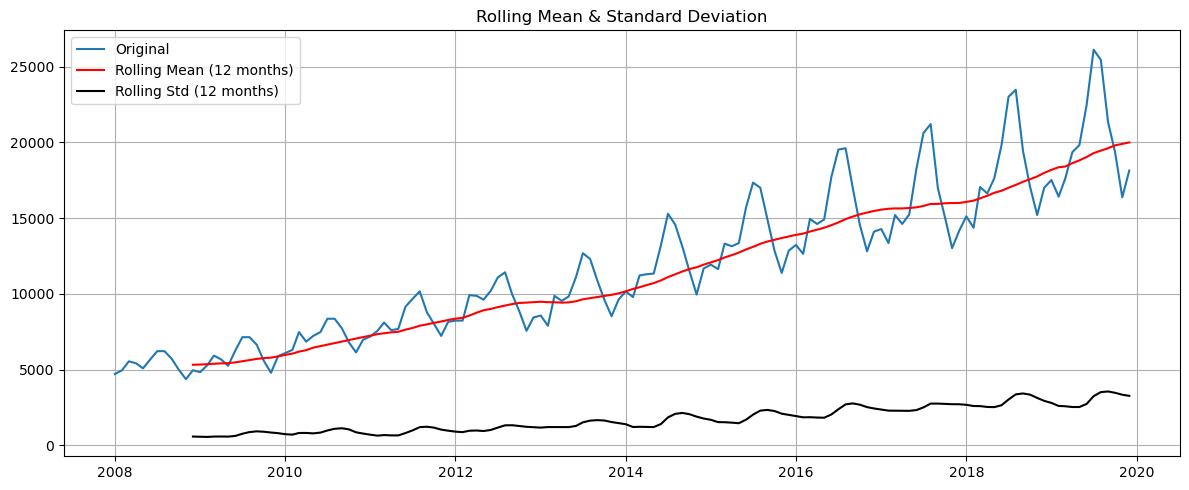

ADF Statistic: 0.8153688792061309
p-value: 0.9918802434376423
Critical Value 1%: -3.4816817173418295
Critical Value 5%: -2.8840418343195267
Critical Value 10%: -2.578770059171598


In [78]:
rolling_mean = df['MonthlyPassengers'].rolling(window=12).mean()
rolling_std = df['MonthlyPassengers'].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(df['MonthlyPassengers'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='red')
plt.plot(rolling_std, label='Rolling Std (12 months)', color='black')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test
result = adfuller(df['MonthlyPassengers'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')


Since p-value > 0.05, the original time series is non-stationary.

### Data Distribution

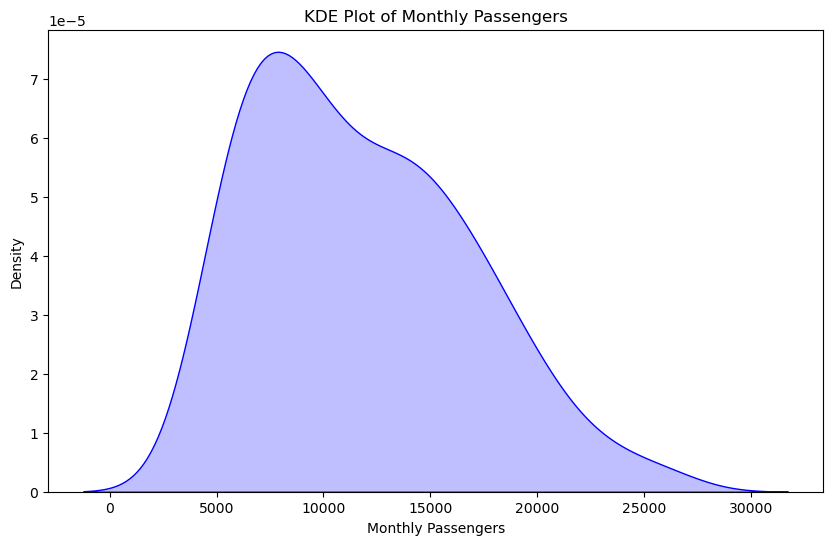

In [79]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['MonthlyPassengers'], shade=True, color='blue')
plt.title('KDE Plot of Monthly Passengers')
plt.xlabel('Monthly Passengers')
plt.ylabel('Density')
plt.show()

The distribution is right-skewed, with a long tail on the higher end. To address this skewness and improve model performance, applying a log transformation would be effective. The log transformation compresses the range of high values, reduces the skew, and helps stabilize variance, making the data more suitable for modeling and improving predictive accuracy.

### Log Transformation to stabilize variance 

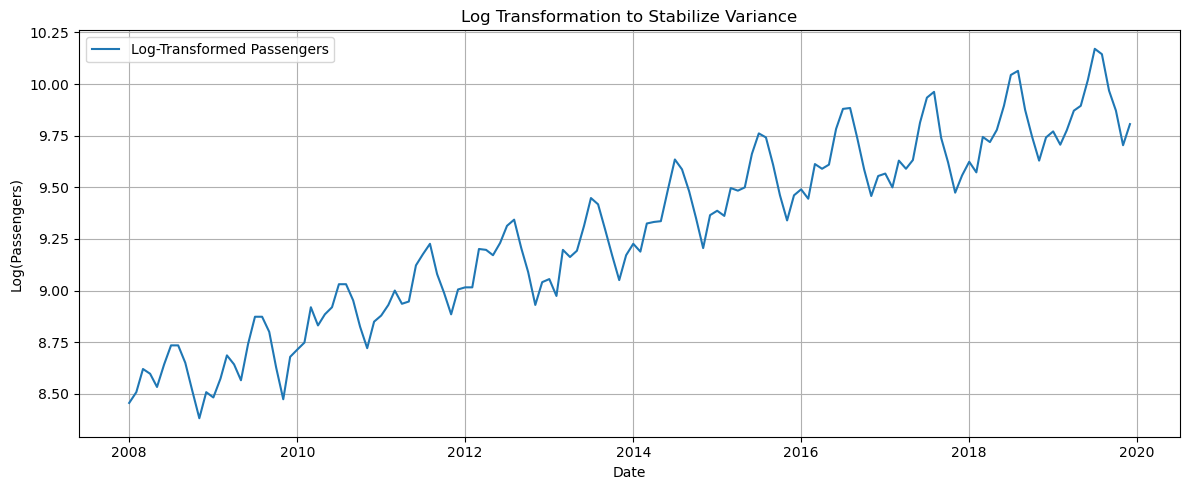

In [80]:
df['LogPassengers'] = np.log(df['MonthlyPassengers'])

plt.figure(figsize=(12, 5))
plt.plot(df['LogPassengers'], label='Log-Transformed Passengers')
plt.title('Log Transformation to Stabilize Variance')
plt.xlabel('Date')
plt.ylabel('Log(Passengers)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


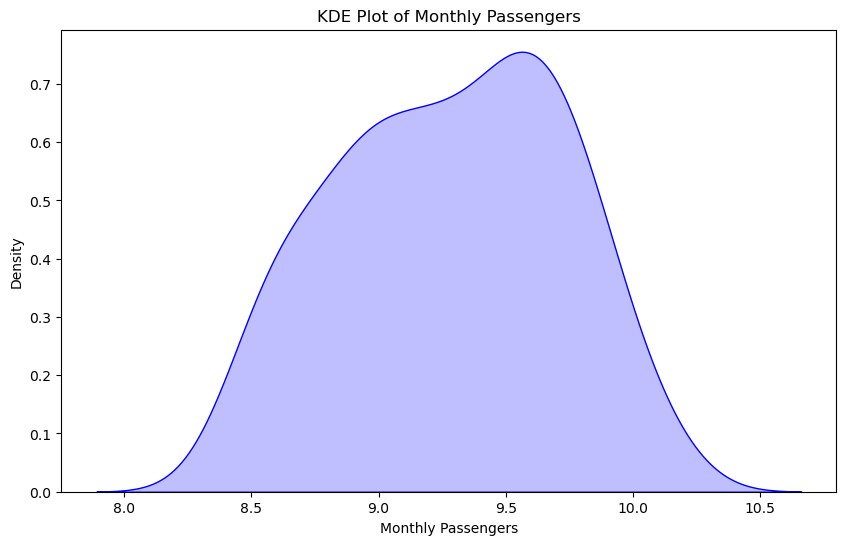

In [81]:
# Plot KDE for Monthly Passengers
plt.figure(figsize=(10, 6))
sns.kdeplot(df['LogPassengers'], shade=True, color='blue')
plt.title('KDE Plot of Monthly Passengers')
plt.xlabel('Monthly Passengers')
plt.ylabel('Density')
plt.show()

After the logarithm transformation, distribution appears more symmetrical, with reduced skewness.

### Differencing of target variable

Apply first-order difference to remove linear trend. 

Seasonal difference (lag 12): removes yearly seasonality

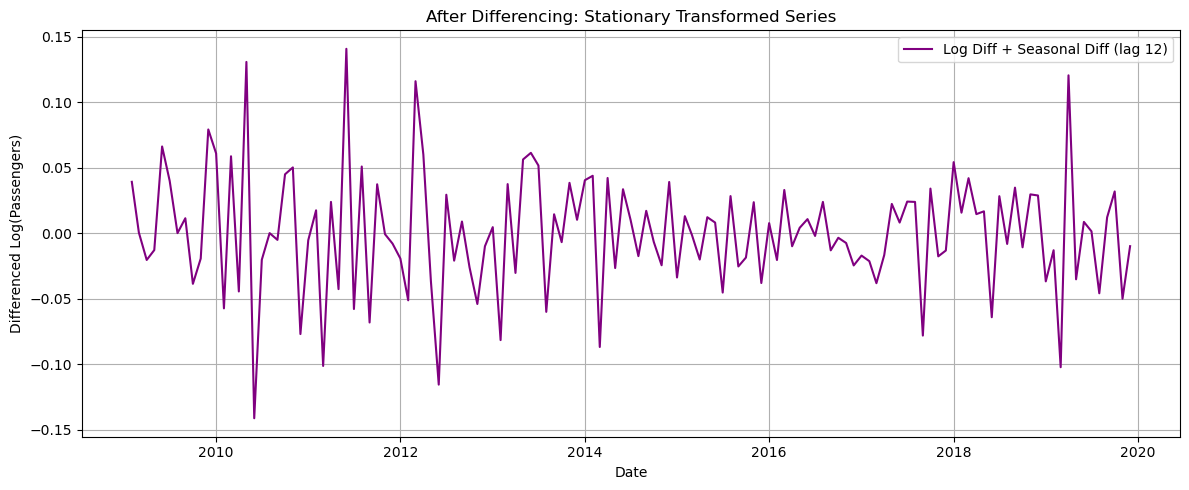

In [82]:
df['LogDiff'] = df['LogPassengers'].diff().dropna()
df['LogDiffSeasonal'] = df['LogDiff'].diff(12).dropna()

plt.figure(figsize=(12, 5))
plt.plot(df['LogDiffSeasonal'], label='Log Diff + Seasonal Diff (lag 12)', color='purple')
plt.title('After Differencing: Stationary Transformed Series')
plt.xlabel('Date')
plt.ylabel('Differenced Log(Passengers)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Check for Stationarity after transformation using ADF Test

In [83]:
# Perform the ADF test on 'LogDiff'
result_diff2 = adfuller(df['LogDiff'].dropna())

# Output the ADF test results
print("ADF Statistic (after log + diff):", result_diff2[0])
print("p-value:", result_diff2[1])
for key, value in result_diff2[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic (after log + diff): -2.717130598388139
p-value: 0.07112054815085772
Critical Value 1%: -3.4825006939887997
Critical Value 5%: -2.884397984161377
Critical Value 10%: -2.578960197753906


In [84]:
# Perform the ADF test on 'LogDiff'
result_diff2 = adfuller(df['LogDiff'].diff().diff().dropna(), autolag='AIC')
# Output the ADF test results
print("ADF Statistic (after log + diff):", result_diff2[0])
print("p-value:", result_diff2[1])
for key, value in result_diff2[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic (after log + diff): -9.824010905497875
p-value: 5.2461332951720724e-17
Critical Value 1%: -3.4833462346078936
Critical Value 5%: -2.8847655969877666
Critical Value 10%: -2.5791564575459813


Since the p-value of the Augmented Dickey-Fuller (ADF) test is less than 0.05, we can reject the null hypothesis that the time series has a unit root (i.e., is non-stationary). This indicates that the nonseasonal part of the time series is stationary after 2nd-order differencing (d=2)

In [85]:
result_diff = adfuller(df['LogDiffSeasonal'].dropna())

print("ADF Statistic (after log + diff):", result_diff[0])
print("p-value:", result_diff[1])
for key, value in result_diff[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic (after log + diff): -4.4433249418311425
p-value: 0.00024859123113838495
Critical Value 1%: -3.4870216863700767
Critical Value 5%: -2.8863625166643136
Critical Value 10%: -2.580009026141913


For the seasonal component, the series is stationary after 1st-order seasonal differencing (D=1) with a seasonal period of 12 (s=12). 
At this stage, we can expect one or few of the following parameters for the SARIMA model:

d=2: Nonseasonal differencing of order 2.

D=1: Seasonal differencing of order 1.

s=12: Seasonal period of 12.

In [86]:
log_series = df['LogPassengers']
log_diff = log_series.diff().dropna()

# Seasonal differencing (12-month lag)
log_diff_seasonal = log_diff.diff(12).dropna()

<Figure size 1200x400 with 0 Axes>

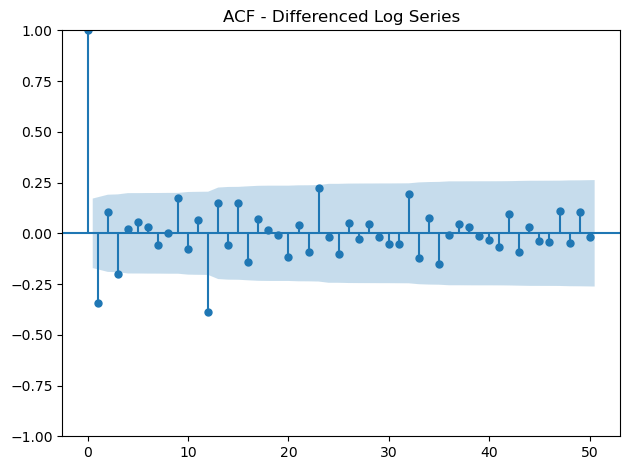

<Figure size 1200x400 with 0 Axes>

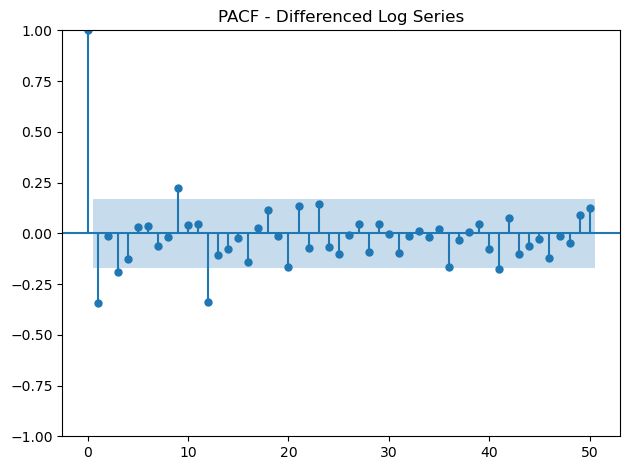

In [87]:
# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(log_diff_seasonal, lags=50)
plt.title('ACF - Differenced Log Series')
plt.tight_layout()
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(log_diff_seasonal, lags=50)
plt.title('PACF - Differenced Log Series')
plt.tight_layout()
plt.show()

- From the PACF plot, there is a significant partial autocorrelation at lag 1 in the seasonal differenced series. This suggests that P = 1 possible for the seasonal AR order.
- From the ACF plot, there is a significant autocorrelation at lag 1 in the seasonal differenced series, indicating possible Q = 1 for the seasonal MA order.

# 4 SARIMA Model

SARIMA(p,d,q)(P,D,Q)[s]

p: Uses n previous value

d: n non-seasonal difference (remove trend)

q: n previous error term

P: n seasonal lag (e.g., uses value from 12 months ago)

D: seasonal differencing (difference from 12 months ago)

Q: n seasonal error term

s=12: yearly seasonality in monthly data

### Splitting the data

In [88]:
train = log_series.iloc[:-24]
test = log_series.iloc[-24:]

### Finding the optimal values for the SARIMAX model components

In [89]:
auto_arima(train, m=12, seasonal=True, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-386.375, Time=1.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-277.702, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-381.231, Time=0.55 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-341.622, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-118.985, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-389.777, Time=1.13 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-365.957, Time=0.47 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-387.750, Time=3.17 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-383.803, Time=1.10 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-385.835, Time=2.82 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-390.768, Time=0.51 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-366.343, Time=0.37 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-386.812, Time=1.09 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-388.941, Time=2.46 sec
 ARIMA(1,0,2)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 201.768
Date:                              Wed, 23 Apr 2025   AIC                           -393.537
Time:                                      18:36:57   BIC                           -380.126
Sample:                                  01-01-2008   HQIC                          -388.099
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0180      0.010      1.811      0.070      -0.001       0.038
ar.L1          0.6165      0.088      6.975      0.000       0.443       0.790
ar.L2          0.2342      0.092      2.532      0.011       0.053       0.415
ma.S.L12      -0.5557      0.120     -4.619      0.000      -0.791      -0.320
sigma2         0.0013      0.000      7.469      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.51
Prob(Q):                              1.00   Prob(JB):                         0.17
Heteroskedasticity (H):               0.40   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model (2,0,0)x(0,1,1,12) shows good quality however intercept is not statistically significant.

### Training model (1 model)

In [90]:
model1 = SARIMAX(train,
                order=(2, 0, 0),          
                seasonal_order=(0, 1, 1, 12),  
                enforce_stationarity=False,
                enforce_invertibility=False)
results1 = model1.fit()
print(results1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27895D+00    |proj g|=  3.97717D+00

At iterate    5    f= -1.30223D+00    |proj g|=  3.58846D+00

At iterate   10    f= -1.45698D+00    |proj g|=  4.94555D+00


 This problem is unconstrained.



At iterate   15    f= -1.48026D+00    |proj g|=  1.48243D-02

At iterate   20    f= -1.48027D+00    |proj g|=  4.02453D-02

At iterate   25    f= -1.48034D+00    |proj g|=  7.60966D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     75      2     0     0   7.201D-03  -1.480D+00
  F =  -1.4803365543286640     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                      SARIMAX Results                                       
Dep. Variable:                        LogPassengers   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


This SARIMA model (without intercept) shows a good fit with reasonably significant AR terms and a strong seasonal MA component. The AIC, BIC, and HQIC values suggest that this is a well-fitting model.

The model does not show significant autocorrelation or non-normality in the residuals.

#### Forecat evaluation metrics

In [91]:
forecast_log1 = results1.get_forecast(steps=24)
forecast1 = np.exp(forecast_log1.predicted_mean) 
actual1 = np.exp(test) 
rmse1 = np.sqrt(mean_squared_error(actual1, forecast1))

mae1 = mean_absolute_error(actual1, forecast1)
mape1 = np.mean(np.abs((actual1 - forecast1) / actual1)) * 100

print("📉 Forecast Evaluation on Test Set:")
print(f"RMSE: {rmse1:.2f}")
print(f"MAE : {mae1:.2f}")
print(f"MAPE: {mape1:.2f}%")

📉 Forecast Evaluation on Test Set:
RMSE: 2334.82
MAE : 2134.32
MAPE: 10.96%


MAPE 10.96% indicates the model's predictions are off by 10.96% on average.
This metric suggests room for improvement, and the model will be optimized to reduce the MAPE for better forecast accuracy.

### Optimizing grid search with fixed parameters based on AIC

In [92]:
# Fix s=12
s = 12

p = q = d = P = Q = D = [0, 1, 2]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

print("Running optimized grid search...\n")

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train,
                             order=order,
                             seasonal_order=seasonal_order,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
            print(f"SARIMA{order}x{seasonal_order}12 - AIC: {results.aic:.2f}")
        except:
            continue

print("\n✅ Best SARIMA Parameters:")
print(f"Order (p,d,q): {best_order}")
print(f"Seasonal Order (P,D,Q,s): {best_seasonal_order}")
print(f"Best AIC: {best_aic:.2f}")

Running optimized grid search...

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC: 867.42
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC: 673.77
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC: 602.55
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC: -116.91
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC: -138.91
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC: -162.61
SARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC: -163.71
SARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC: -197.64
SARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC: 2594.14
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC: -272.07
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC: -278.09
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC: -246.59
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC: -176.34
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC: -225.00
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC: -220.23
SARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC: -179.37
SARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC: -183.60
SARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC: 2862.20
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC: -240.11
SARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC: -245.65
SARIMA(0, 0, 0)x(2, 0, 2, 12)

### Train SARIMA model (2)

In [93]:
model = SARIMAX(train,
                order=(1, 0, 0),          
                seasonal_order=(1, 0, 1, 12),  
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11181D+00    |proj g|=  7.14275D+00


 This problem is unconstrained.



At iterate    5    f= -1.57802D+00    |proj g|=  2.19490D-01

At iterate   10    f= -1.61370D+00    |proj g|=  3.97002D+00

At iterate   15    f= -1.63305D+00    |proj g|=  1.28490D-01

At iterate   20    f= -1.63347D+00    |proj g|=  1.82531D+00

At iterate   25    f= -1.63442D+00    |proj g|=  8.45753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     42      1     0     0   1.542D-03  -1.634D+00
  F =  -1.6344224885798049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                       
Dep. Variable:      

Based on the analysis, Model 2 fits the data better than Model 1, as evidenced by its lower AIC, BIC, and HQIC values. These lower values indicate that Model 2 is more efficient in explaining the data, potentially leading to better generalization.

Given that Model 2 outperforms Model 1 in terms of fit quality, the analysis will continue using SARIMA Model 2 for further modeling and forecasting.

#### Residual analysis

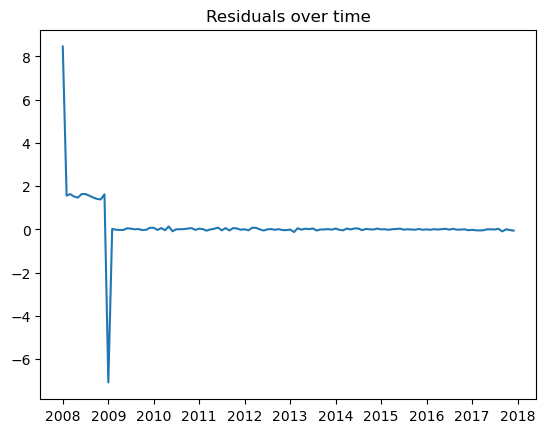

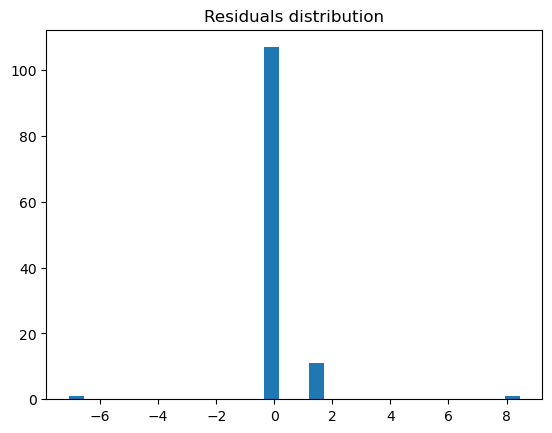

In [94]:
residuals = results.resid
plt.plot(residuals)
plt.title("Residuals over time")
plt.show()

plt.hist(residuals, bins=30)
plt.title("Residuals distribution")
plt.show()

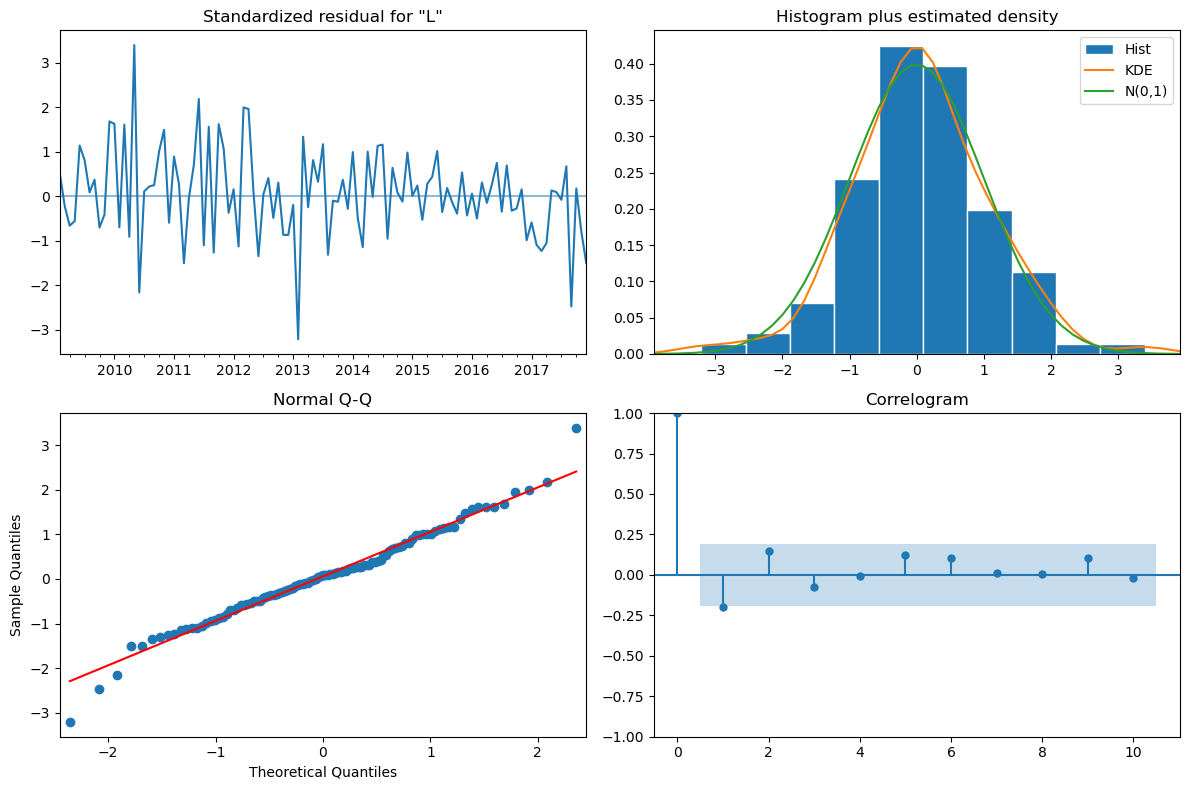

In [95]:
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

Analysis suggested that residuals:
- are stable after 2009; initial spikes are likely due to model warm-up.
- approximately follow a normal distribution, which supports the assumptions of the model.
- distribution is sharply centered.
- are uncorrelated, so the model has likely captured all time-dependent structure.

#### Ljung-Box test on the residuals

In [96]:
lags = 10
ljung_box_results = acorr_ljungbox(residuals, lags=lags)

print("Ljung-Box Test Results:")
print(ljung_box_results)

Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    3.207483   0.073302
2    6.576046   0.037328
3    9.179005   0.027003
4   11.136243   0.025075
5   12.680241   0.026567
6   13.745878   0.032607
7   14.423924   0.044135
8   14.913609   0.060847
9   15.176024   0.086213
10  15.240672   0.123531


At Lag 1 (p = 0.073), the p-value is above the 0.05 threshold, indicating no significant autocorrelation at the immediate previous time step. This suggests that the SARIMA model has effectively captured the short-term dependencies in the data — a positive sign, as lag 1 is often the most critical in time series modeling.

However, from lags 2 to 7, the p-values are below 0.05, pointing to significant autocorrelations in the residuals over the medium term.

#### Forecat evaluation metrics

In [97]:
forecast_log = results.get_forecast(steps=24)
forecast = np.exp(forecast_log.predicted_mean) 
actual = np.exp(test) 

In [98]:
rmse = np.sqrt(mean_squared_error(actual, forecast))
mae = mean_absolute_error(actual, forecast)
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print("📉 Forecast Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


📉 Forecast Evaluation on Test Set:
RMSE: 1196.16
MAE : 927.14
MAPE: 4.68%


The model's predictions are, on average, off by 4.68% from the actual values.  
Given the lower MAPE and overall reduced error metrics (RMSE and MAE), Model 2 is the preferred model for forecasting compared to Model 1. 

### Confidence intervals

In [99]:
forecast_mean_log = forecast_log.predicted_mean
conf_int_log = forecast_log.conf_int()

# Inverse transform from log if needed
forecast_mean = np.exp(forecast_mean_log)
conf_int = np.exp(conf_int_log)

df_forecast = pd.DataFrame({
    'MonthlyPassengers': df['MonthlyPassengers'],
    'Forecast': forecast_mean,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
}, index=forecast_mean.index)

df_forecast = df_forecast.round(0)
print(df_forecast)

            MonthlyPassengers  Forecast  Lower CI  Upper CI
2018-01-01              15120   14844.0   13785.0   15984.0
2018-02-01              14364   14445.0   13125.0   15896.0
2018-03-01              17052   17083.0   15334.0   19031.0
2018-04-01              16632   16846.0   15008.0   18909.0
2018-05-01              17640   17489.0   15506.0   19725.0
2018-06-01              19824   20935.0   18503.0   23687.0
2018-07-01              23016   23693.0   20897.0   26862.0
2018-08-01              23478   23989.0   21129.0   27235.0
2018-09-01              19446   20266.0   17834.0   23030.0
2018-10-01              17094   17761.0   15619.0   20196.0
2018-11-01              15204   15481.0   13609.0   17611.0
2018-12-01              17010   17283.0   15189.0   19667.0
2019-01-01              17514   17907.0   15652.0   20488.0
2019-02-01              16422   17238.0   15013.0   19792.0
2019-03-01              17598   20256.0   17601.0   23312.0
2019-04-01              19362   19831.0 

### Plot the forecast vs. actual

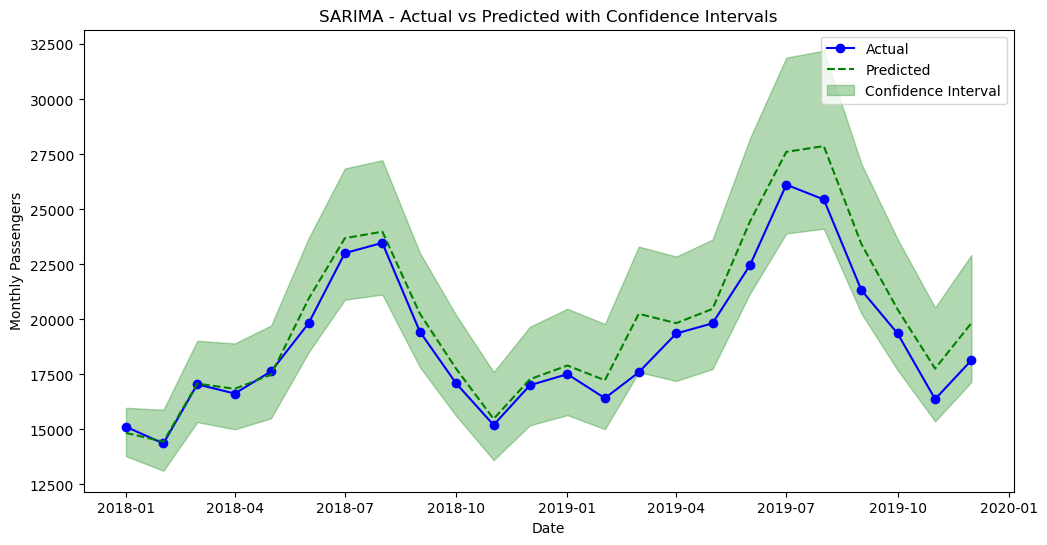

In [122]:
plt.figure(figsize=(12, 6))

plt.plot(df_forecast.index, df_forecast['MonthlyPassengers'], label='Actual', color='blue', marker='o')

plt.plot(df_forecast.index, df_forecast['Forecast'], label='Predicted', color='green', linestyle='--')

plt.fill_between(df_forecast.index, df_forecast['Lower CI'], df_forecast['Upper CI'], color='green', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Monthly Passengers')
plt.title('SARIMA - Actual vs Predicted with Confidence Intervals')
plt.legend()
plt.show()

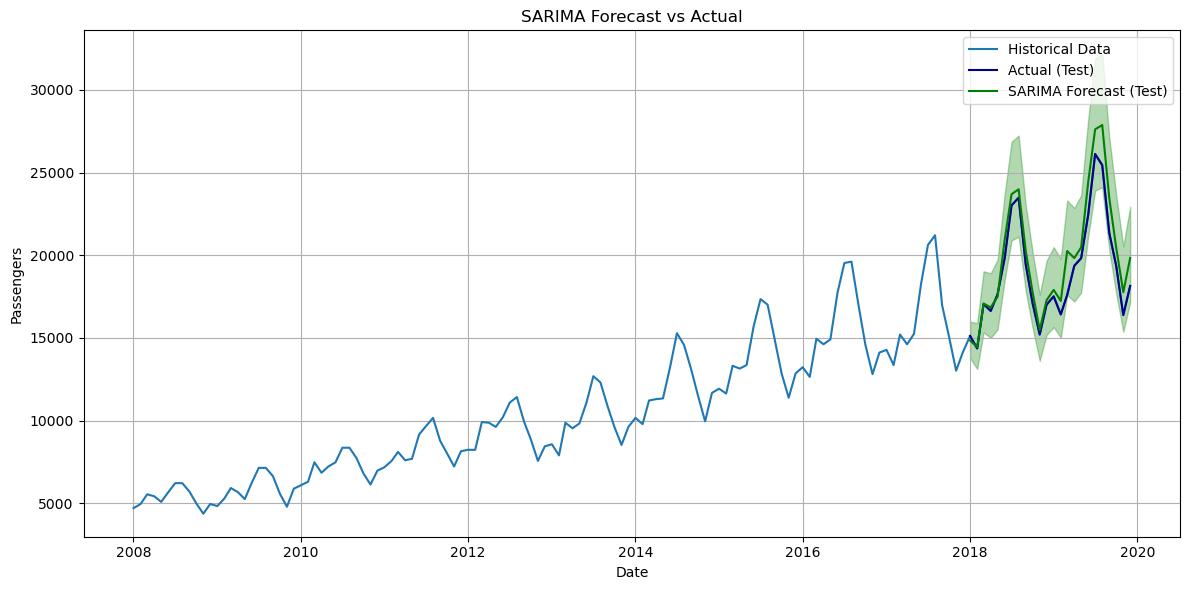

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MonthlyPassengers'], label='Historical Data')
plt.plot(actual.index, actual, label='Actual (Test)', color='darkblue')
plt.plot(forecast.index, forecast, label='SARIMA Forecast (Test)', color='green')
plt.fill_between(forecast.index,
                 np.exp(forecast_log.conf_int().iloc[:, 0]),
                 np.exp(forecast_log.conf_int().iloc[:, 1]),
                 color='green', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The SARIMA model effectively captures the underlying temporal patterns. While there is a minor tendency to slightly overestimate peak values, the model maintains overall alignment with observed data. The forecast confidence intervals appropriately widen over time, reflecting growing uncertainty in longer-term predictions, yet all actual values remain within the predicted bounds—indicating well-calibrated uncertainty estimates.

# 5 Prophet model

In [102]:
df2 = df.copy()
df2.head()

,MonthlyPassengers,Year,Month,LogPassengers,LogDiff,LogDiffSeasonal
Month,,,,,,
2008-01-01,4704,2008,1,8.456168,NaN,NaN
2008-02-01,4956,2008,2,8.508354,0.052186,NaN
2008-03-01,5544,2008,3,8.620472,0.112117,NaN
2008-04-01,5418,2008,4,8.597482,-0.022990,NaN
2008-05-01,5082,2008,5,8.533460,-0.064022,NaN


In [103]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2008-01-01 to 2019-12-01
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MonthlyPassengers  144 non-null    int64  
 1   Year               144 non-null    int32  
 2   Month              144 non-null    int32  
 3   LogPassengers      144 non-null    float64
 4   LogDiff            143 non-null    float64
 5   LogDiffSeasonal    131 non-null    float64
dtypes: float64(3), int32(2), int64(1)
memory usage: 10.8 KB


### Preparing the data

In [104]:
df2 = df2.rename(columns={ 'MonthlyPassengers': 'y'})
df2.drop(columns=['Year', 'Month', 'LogPassengers', 'LogDiff', 'LogDiffSeasonal'], inplace=True)

df2.reset_index(inplace=True)

# Rename the 'Month' column to 'ds' for Prophet
df2 = df2.rename(columns={'Month': 'ds', 'MonthlyPassengers': 'y'})

df2['ds'] = pd.to_datetime(df2['ds'])
df2.head()

,ds,y
0,2008-01-01,4704
1,2008-02-01,4956
2,2008-03-01,5544
3,2008-04-01,5418
4,2008-05-01,5082


In [105]:
df2.dtypes

ds    datetime64[ns]
y              int64
dtype: object

### Splitting the data

In [106]:
train2 = df2.iloc[:-24]
test2 = df2.iloc[-24:]

In [107]:
train2['y'] = np.log(train2['y'] + 1) 

## Train the Prophet model (1)

In [108]:
model2 = Prophet(
    interval_width=0.95, 
    yearly_seasonality=True,
    seasonality_mode='multiplicative')

model2.fit(train2)

18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
future_dates = model2.make_future_dataframe(periods=24, freq='MS')
future_dates.tail()

,ds
139,2019-08-01
140,2019-09-01
141,2019-10-01
142,2019-11-01
143,2019-12-01


### Forecast test set and confidence intervals

In [110]:
forecast2 = model2.predict(future_dates)
forecast2['yhat'] = np.exp(forecast2['yhat']) - 1
forecast2['yhat_lower'] = np.exp(forecast2['yhat_lower']) - 1  
forecast2['yhat_upper'] = np.exp(forecast2['yhat_upper']) - 1  

# Combine the actual values from the test set with the forecasted values
result_df = forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test2)) 

result_df['y_actual'] = test2['y'].values
print(result_df)

            ds          yhat    yhat_lower    yhat_upper  y_actual
120 2018-01-01  15122.503703  14186.999075  16046.786430     15120
121 2018-02-01  14915.189292  14005.678946  15909.855646     14364
122 2018-03-01  17321.539930  16273.010218  18495.438255     17052
123 2018-04-01  16572.480466  15563.624896  17625.338724     16632
124 2018-05-01  16702.357610  15693.454057  17792.213102     17640
125 2018-06-01  19311.922725  18185.128130  20619.320919     19824
126 2018-07-01  21455.657205  20201.799328  22924.118113     23016
127 2018-08-01  21283.363125  19893.058197  22850.806374     23478
128 2018-09-01  18483.445915  17059.982315  19827.177619     19446
129 2018-10-01  16014.518950  14724.362740  17227.003126     17094
130 2018-11-01  13907.251810  12893.096175  14964.267255     15204
131 2018-12-01  15826.841417  14521.390702  17257.069687     17010
132 2019-01-01  16152.554604  14662.647664  17669.487351     17514
133 2019-02-01  16063.008741  14575.357591  17592.798025     1

### Plotting the actual vs predicted values (1)

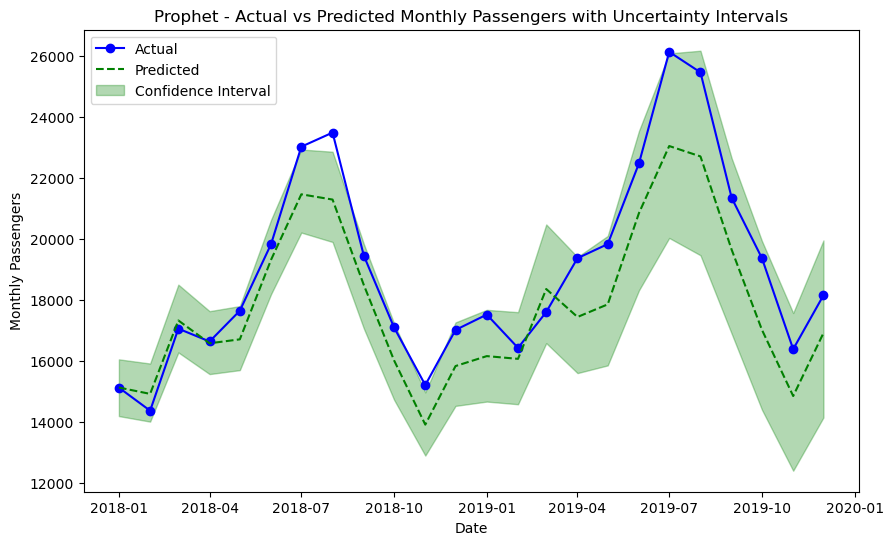

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['ds'], result_df['y_actual'], label='Actual', color='blue', marker='o')
plt.plot(result_df['ds'], result_df['yhat'], label='Predicted', color='green', linestyle='--')
plt.fill_between(result_df['ds'], result_df['yhat_lower'], result_df['yhat_upper'], color='green', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Monthly Passengers')
plt.title('Prophet - Actual vs Predicted Monthly Passengers with Uncertainty Intervals')
plt.legend()
plt.show()

The predicted trend closely mirrors the actual values, particularly in capturing seasonal patterns and key inflection points, such as the mid-2018 and mid-2019 peaks. This alignment indicates that the Prophet model has effectively learned both the trend and seasonal components of the time series. However, at periods 7 and 8, the actual values fall outside the model’s confidence intervals, suggesting potential underestimation of uncertainty

#### Forecat evaluation metrics

In [112]:
y_true = test2['y'].values

y_pred = forecast2['yhat'][-len(test2):].values

# MAE (Mean Absolute Error)
mae2 = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse2 = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape2 = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae2}")
print(f"RMSE: {rmse2}")
print(f"MAPE: {mape2}%")

MAE: 1303.0986699933967
RMSE: 1529.701416900605
MAPE: 6.53714513138985%


On average, the model's predictions are off by 6.54% relative to the actual values. 

### Cross-validation of Prophet model

In [113]:
df_cv = cross_validation(
    model2,
    initial='1095 days',  
    period='180 days',  
    horizon='365 days' 
)

df_metrics = performance_metrics(df_cv)

print("Performance Metrics:")
print(df_metrics.head())

  0%|          | 0/13 [00:00<?, ?it/s]

18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing
18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:52 - cmdstanpy - INFO - Chain [1] done processing
18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1] done processing
18:49:53 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1] done processing
18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
18:49:54 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1]

Performance Metrics:
  horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  0.003051  0.055236  0.046578  0.004985  0.004573  0.004987   
1 41 days  0.004918  0.070129  0.055265  0.005954  0.004573  0.005945   
2 42 days  0.004908  0.070056  0.055193  0.005941  0.004573  0.005935   
3 46 days  0.004871  0.069793  0.053720  0.005778  0.004573  0.005773   
4 47 days  0.004098  0.064013  0.047300  0.005097  0.004394  0.005087   

   coverage  
0  0.466667  
1  0.466667  
2  0.466667  
3  0.466667  
4  0.533333  


The model shows consistent performance with very low errors, especially in terms of MSE, RMSE, MAE, and the percentage error metrics (MAPE, MDAPE, SMAPE).

The slight increase in error metrics with the forecast horizon is typical for time series forecasting, as uncertainty grows with time.

The coverage is relatively stable, with a slight improvement for the longest horizon.

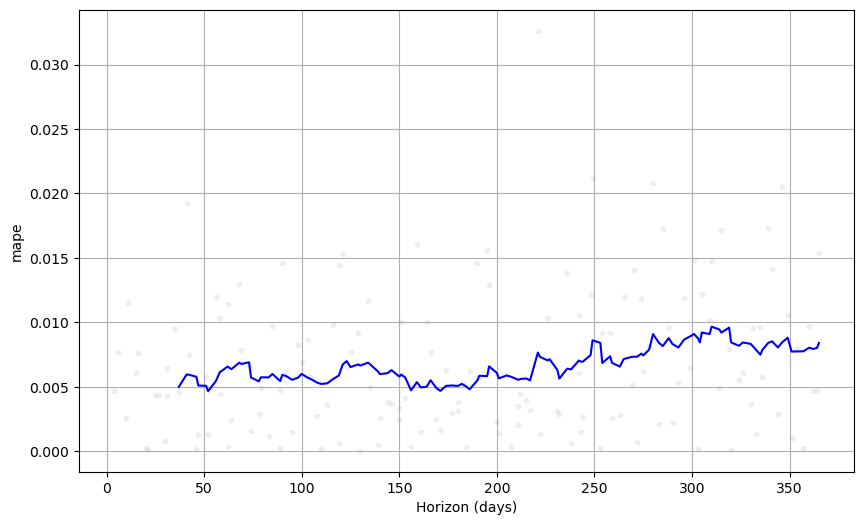

In [114]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

The MAPE increases as the forecast horizon extends (from 5% to 10%), which is typical in time series forecasting. The model captures short-term trends well but struggles to maintain accuracy over longer horizons. Overall, the model performs quite well and is stable across different forecast horizons.

## Prophet Model Optimization

In [ ]:
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1, 10, 30],
}


def evaluate_model(model, metric_func):
    df_cv5 = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    return metric_func(df_cv5['y'], df_cv5['yhat'])


# Grid search
best_params5 = {}
best_score5 = float('inf')

for mode in param_grid['seasonality_mode']:
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Create a model with the current hyperparameters
            model5 = Prophet(seasonality_mode=mode, changepoint_prior_scale=cps, seasonality_prior_scale=sps)
            model5.fit(train2)

            # Evaluate the model using Mean Absolute Error (MAE)
            score = evaluate_model(model5, mean_absolute_error)

            # Update best parameters if necessary
            if score < best_score5:
                best_score5 = score
                best_params5 = {
                    'seasonality_mode': mode,
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

print(best_params5)
print(best_score5)

# Create the best model with the optimal hyperparameters
best_model5 = Prophet(**best_params5)
best_model5.fit(train2)

01:09:38 - cmdstanpy - INFO - Chain [1] start processing
01:09:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

01:09:38 - cmdstanpy - INFO - Chain [1] start processing
01:09:53 - cmdstanpy - INFO - Chain [1] done processing
01:09:53 - cmdstanpy - INFO - Chain [1] start processing
01:09:53 - cmdstanpy - INFO - Chain [1] done processing
01:09:54 - cmdstanpy - INFO - Chain [1] start processing
01:09:54 - cmdstanpy - INFO - Chain [1] done processing
01:09:54 - cmdstanpy - INFO - Chain [1] start processing
01:09:54 - cmdstanpy - INFO - Chain [1] done processing
01:09:55 - cmdstanpy - INFO - Chain [1] start processing
01:09:55 - cmdstanpy - INFO - Chain [1] done processing
01:09:55 - cmdstanpy - INFO - Chain [1] start processing
01:09:55 - cmdstanpy - INFO - Chain [1] done processing
01:09:55 - cmdstanpy - INFO - Chain [1] start processing
01:09:56 - cmdstanpy - INFO - Chain [1] done processing
01:09:56 - cmdstanpy - INFO - Chain [1] start processing
01:09:56 - cmdstanpy - INFO - Chain [1] done processing
01:09:56 - cmdstanpy - INFO - Chain [1] start processing
01:09:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:10:00 - cmdstanpy - INFO - Chain [1] start processing
01:10:22 - cmdstanpy - INFO - Chain [1] done processing
01:10:22 - cmdstanpy - INFO - Chain [1] start processing
01:10:22 - cmdstanpy - INFO - Chain [1] done processing
01:10:22 - cmdstanpy - INFO - Chain [1] start processing
01:10:23 - cmdstanpy - INFO - Chain [1] done processing
01:10:23 - cmdstanpy - INFO - Chain [1] start processing
01:10:23 - cmdstanpy - INFO - Chain [1] done processing
01:10:23 - cmdstanpy - INFO - Chain [1] start processing
01:10:23 - cmdstanpy - INFO - Chain [1] done processing
01:10:24 - cmdstanpy - INFO - Chain [1] start processing
01:10:24 - cmdstanpy - INFO - Chain [1] done processing
01:10:24 - cmdstanpy - INFO - Chain [1] start processing
01:10:25 - cmdstanpy - INFO - Chain [1] done processing
01:10:25 - cmdstanpy - INFO - Chain [1] start processing
01:10:25 - cmdstanpy - INFO - Chain [1] done processing
01:10:25 - cmdstanpy - INFO - Chain [1] start processing
01:10:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:10:29 - cmdstanpy - INFO - Chain [1] start processing
01:10:42 - cmdstanpy - INFO - Chain [1] done processing
01:10:42 - cmdstanpy - INFO - Chain [1] start processing
01:10:42 - cmdstanpy - INFO - Chain [1] done processing
01:10:43 - cmdstanpy - INFO - Chain [1] start processing
01:10:43 - cmdstanpy - INFO - Chain [1] done processing
01:10:43 - cmdstanpy - INFO - Chain [1] start processing
01:10:43 - cmdstanpy - INFO - Chain [1] done processing
01:10:43 - cmdstanpy - INFO - Chain [1] start processing
01:10:44 - cmdstanpy - INFO - Chain [1] done processing
01:10:44 - cmdstanpy - INFO - Chain [1] start processing
01:10:44 - cmdstanpy - INFO - Chain [1] done processing
01:10:44 - cmdstanpy - INFO - Chain [1] start processing
01:10:45 - cmdstanpy - INFO - Chain [1] done processing
01:10:45 - cmdstanpy - INFO - Chain [1] start processing
01:10:45 - cmdstanpy - INFO - Chain [1] done processing
01:10:45 - cmdstanpy - INFO - Chain [1] start processing
01:10:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:10:49 - cmdstanpy - INFO - Chain [1] start processing
01:11:12 - cmdstanpy - INFO - Chain [1] done processing
01:11:12 - cmdstanpy - INFO - Chain [1] start processing
01:11:36 - cmdstanpy - INFO - Chain [1] done processing
01:11:36 - cmdstanpy - INFO - Chain [1] start processing
01:12:03 - cmdstanpy - INFO - Chain [1] done processing
01:12:03 - cmdstanpy - INFO - Chain [1] start processing
01:12:03 - cmdstanpy - INFO - Chain [1] done processing
01:12:03 - cmdstanpy - INFO - Chain [1] start processing
01:12:04 - cmdstanpy - INFO - Chain [1] done processing
01:12:04 - cmdstanpy - INFO - Chain [1] start processing
01:12:05 - cmdstanpy - INFO - Chain [1] done processing
01:12:05 - cmdstanpy - INFO - Chain [1] start processing
01:12:05 - cmdstanpy - INFO - Chain [1] done processing
01:12:05 - cmdstanpy - INFO - Chain [1] start processing
01:12:06 - cmdstanpy - INFO - Chain [1] done processing
01:12:06 - cmdstanpy - INFO - Chain [1] start processing
01:12:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:12:09 - cmdstanpy - INFO - Chain [1] start processing
01:12:20 - cmdstanpy - INFO - Chain [1] done processing
01:12:20 - cmdstanpy - INFO - Chain [1] start processing
01:12:38 - cmdstanpy - INFO - Chain [1] done processing
01:12:38 - cmdstanpy - INFO - Chain [1] start processing
01:13:05 - cmdstanpy - INFO - Chain [1] done processing
01:13:05 - cmdstanpy - INFO - Chain [1] start processing
01:13:05 - cmdstanpy - INFO - Chain [1] done processing
01:13:05 - cmdstanpy - INFO - Chain [1] start processing
01:13:06 - cmdstanpy - INFO - Chain [1] done processing
01:13:06 - cmdstanpy - INFO - Chain [1] start processing
01:13:06 - cmdstanpy - INFO - Chain [1] done processing
01:13:06 - cmdstanpy - INFO - Chain [1] start processing
01:13:07 - cmdstanpy - INFO - Chain [1] done processing
01:13:07 - cmdstanpy - INFO - Chain [1] start processing
01:13:07 - cmdstanpy - INFO - Chain [1] done processing
01:13:07 - cmdstanpy - INFO - Chain [1] start processing
01:13:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:13:10 - cmdstanpy - INFO - Chain [1] start processing
01:13:30 - cmdstanpy - INFO - Chain [1] done processing
01:13:30 - cmdstanpy - INFO - Chain [1] start processing
01:13:53 - cmdstanpy - INFO - Chain [1] done processing
01:13:53 - cmdstanpy - INFO - Chain [1] start processing
01:14:12 - cmdstanpy - INFO - Chain [1] done processing
01:14:12 - cmdstanpy - INFO - Chain [1] start processing
01:14:13 - cmdstanpy - INFO - Chain [1] done processing
01:14:13 - cmdstanpy - INFO - Chain [1] start processing
01:14:13 - cmdstanpy - INFO - Chain [1] done processing
01:14:13 - cmdstanpy - INFO - Chain [1] start processing
01:14:14 - cmdstanpy - INFO - Chain [1] done processing
01:14:14 - cmdstanpy - INFO - Chain [1] start processing
01:14:14 - cmdstanpy - INFO - Chain [1] done processing
01:14:14 - cmdstanpy - INFO - Chain [1] start processing
01:14:15 - cmdstanpy - INFO - Chain [1] done processing
01:14:15 - cmdstanpy - INFO - Chain [1] start processing
01:14:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:14:18 - cmdstanpy - INFO - Chain [1] start processing
01:14:37 - cmdstanpy - INFO - Chain [1] done processing
01:14:37 - cmdstanpy - INFO - Chain [1] start processing
01:15:01 - cmdstanpy - INFO - Chain [1] done processing
01:15:01 - cmdstanpy - INFO - Chain [1] start processing
01:15:27 - cmdstanpy - INFO - Chain [1] done processing
01:15:27 - cmdstanpy - INFO - Chain [1] start processing
01:15:57 - cmdstanpy - INFO - Chain [1] done processing
01:15:57 - cmdstanpy - INFO - Chain [1] start processing
01:15:58 - cmdstanpy - INFO - Chain [1] done processing
01:15:58 - cmdstanpy - INFO - Chain [1] start processing
01:15:58 - cmdstanpy - INFO - Chain [1] done processing
01:15:58 - cmdstanpy - INFO - Chain [1] start processing
01:15:59 - cmdstanpy - INFO - Chain [1] done processing
01:15:59 - cmdstanpy - INFO - Chain [1] start processing
01:15:59 - cmdstanpy - INFO - Chain [1] done processing
01:15:59 - cmdstanpy - INFO - Chain [1] start processing
01:15:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:16:01 - cmdstanpy - INFO - Chain [1] start processing
01:16:21 - cmdstanpy - INFO - Chain [1] done processing
01:16:21 - cmdstanpy - INFO - Chain [1] start processing
01:16:44 - cmdstanpy - INFO - Chain [1] done processing
01:16:45 - cmdstanpy - INFO - Chain [1] start processing
01:17:11 - cmdstanpy - INFO - Chain [1] done processing
01:17:11 - cmdstanpy - INFO - Chain [1] start processing
01:17:40 - cmdstanpy - INFO - Chain [1] done processing
01:17:40 - cmdstanpy - INFO - Chain [1] start processing
01:17:41 - cmdstanpy - INFO - Chain [1] done processing
01:17:41 - cmdstanpy - INFO - Chain [1] start processing
01:17:41 - cmdstanpy - INFO - Chain [1] done processing
01:17:41 - cmdstanpy - INFO - Chain [1] start processing
01:17:41 - cmdstanpy - INFO - Chain [1] done processing
01:17:42 - cmdstanpy - INFO - Chain [1] start processing
01:17:42 - cmdstanpy - INFO - Chain [1] done processing
01:17:42 - cmdstanpy - INFO - Chain [1] start processing
01:17:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:17:44 - cmdstanpy - INFO - Chain [1] start processing
01:18:00 - cmdstanpy - INFO - Chain [1] done processing
01:18:00 - cmdstanpy - INFO - Chain [1] start processing
01:18:23 - cmdstanpy - INFO - Chain [1] done processing
01:18:23 - cmdstanpy - INFO - Chain [1] start processing
01:18:37 - cmdstanpy - INFO - Chain [1] done processing
01:18:37 - cmdstanpy - INFO - Chain [1] start processing
01:19:06 - cmdstanpy - INFO - Chain [1] done processing
01:19:06 - cmdstanpy - INFO - Chain [1] start processing
01:19:07 - cmdstanpy - INFO - Chain [1] done processing
01:19:07 - cmdstanpy - INFO - Chain [1] start processing
01:19:07 - cmdstanpy - INFO - Chain [1] done processing
01:19:07 - cmdstanpy - INFO - Chain [1] start processing
01:19:08 - cmdstanpy - INFO - Chain [1] done processing
01:19:08 - cmdstanpy - INFO - Chain [1] start processing
01:19:08 - cmdstanpy - INFO - Chain [1] done processing
01:19:08 - cmdstanpy - INFO - Chain [1] start processing
01:19:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:19:10 - cmdstanpy - INFO - Chain [1] start processing
01:19:18 - cmdstanpy - INFO - Chain [1] done processing
01:19:18 - cmdstanpy - INFO - Chain [1] start processing
01:19:18 - cmdstanpy - INFO - Chain [1] done processing
01:19:18 - cmdstanpy - INFO - Chain [1] start processing
01:19:18 - cmdstanpy - INFO - Chain [1] done processing
01:19:18 - cmdstanpy - INFO - Chain [1] start processing
01:19:19 - cmdstanpy - INFO - Chain [1] done processing
01:19:19 - cmdstanpy - INFO - Chain [1] start processing
01:19:19 - cmdstanpy - INFO - Chain [1] done processing
01:19:19 - cmdstanpy - INFO - Chain [1] start processing
01:19:20 - cmdstanpy - INFO - Chain [1] done processing
01:19:20 - cmdstanpy - INFO - Chain [1] start processing
01:19:20 - cmdstanpy - INFO - Chain [1] done processing
01:19:20 - cmdstanpy - INFO - Chain [1] start processing
01:19:21 - cmdstanpy - INFO - Chain [1] done processing
01:19:21 - cmdstanpy - INFO - Chain [1] start processing
01:19:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:19:24 - cmdstanpy - INFO - Chain [1] start processing
01:19:38 - cmdstanpy - INFO - Chain [1] done processing
01:19:38 - cmdstanpy - INFO - Chain [1] start processing
01:19:39 - cmdstanpy - INFO - Chain [1] done processing
01:19:39 - cmdstanpy - INFO - Chain [1] start processing
01:19:39 - cmdstanpy - INFO - Chain [1] done processing
01:19:39 - cmdstanpy - INFO - Chain [1] start processing
01:19:39 - cmdstanpy - INFO - Chain [1] done processing
01:19:40 - cmdstanpy - INFO - Chain [1] start processing
01:19:40 - cmdstanpy - INFO - Chain [1] done processing
01:19:40 - cmdstanpy - INFO - Chain [1] start processing
01:19:40 - cmdstanpy - INFO - Chain [1] done processing
01:19:40 - cmdstanpy - INFO - Chain [1] start processing
01:19:41 - cmdstanpy - INFO - Chain [1] done processing
01:19:41 - cmdstanpy - INFO - Chain [1] start processing
01:19:41 - cmdstanpy - INFO - Chain [1] done processing
01:19:41 - cmdstanpy - INFO - Chain [1] start processing
01:19:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:19:45 - cmdstanpy - INFO - Chain [1] start processing
01:19:51 - cmdstanpy - INFO - Chain [1] done processing
01:19:51 - cmdstanpy - INFO - Chain [1] start processing
01:19:51 - cmdstanpy - INFO - Chain [1] done processing
01:19:51 - cmdstanpy - INFO - Chain [1] start processing
01:19:51 - cmdstanpy - INFO - Chain [1] done processing
01:19:51 - cmdstanpy - INFO - Chain [1] start processing
01:19:52 - cmdstanpy - INFO - Chain [1] done processing
01:19:52 - cmdstanpy - INFO - Chain [1] start processing
01:19:52 - cmdstanpy - INFO - Chain [1] done processing
01:19:52 - cmdstanpy - INFO - Chain [1] start processing
01:19:52 - cmdstanpy - INFO - Chain [1] done processing
01:19:53 - cmdstanpy - INFO - Chain [1] start processing
01:19:53 - cmdstanpy - INFO - Chain [1] done processing
01:19:53 - cmdstanpy - INFO - Chain [1] start processing
01:19:53 - cmdstanpy - INFO - Chain [1] done processing
01:19:53 - cmdstanpy - INFO - Chain [1] start processing
01:19:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:19:57 - cmdstanpy - INFO - Chain [1] start processing
01:20:22 - cmdstanpy - INFO - Chain [1] done processing
01:20:22 - cmdstanpy - INFO - Chain [1] start processing
01:20:47 - cmdstanpy - INFO - Chain [1] done processing
01:20:47 - cmdstanpy - INFO - Chain [1] start processing
01:21:14 - cmdstanpy - INFO - Chain [1] done processing
01:21:14 - cmdstanpy - INFO - Chain [1] start processing
01:21:15 - cmdstanpy - INFO - Chain [1] done processing
01:21:15 - cmdstanpy - INFO - Chain [1] start processing
01:21:15 - cmdstanpy - INFO - Chain [1] done processing
01:21:15 - cmdstanpy - INFO - Chain [1] start processing
01:21:16 - cmdstanpy - INFO - Chain [1] done processing
01:21:16 - cmdstanpy - INFO - Chain [1] start processing
01:21:16 - cmdstanpy - INFO - Chain [1] done processing
01:21:16 - cmdstanpy - INFO - Chain [1] start processing
01:21:17 - cmdstanpy - INFO - Chain [1] done processing
01:21:17 - cmdstanpy - INFO - Chain [1] start processing
01:21:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:21:20 - cmdstanpy - INFO - Chain [1] start processing
01:21:40 - cmdstanpy - INFO - Chain [1] done processing
01:21:40 - cmdstanpy - INFO - Chain [1] start processing
01:22:04 - cmdstanpy - INFO - Chain [1] done processing
01:22:04 - cmdstanpy - INFO - Chain [1] start processing
01:22:31 - cmdstanpy - INFO - Chain [1] done processing
01:22:32 - cmdstanpy - INFO - Chain [1] start processing
01:22:32 - cmdstanpy - INFO - Chain [1] done processing
01:22:32 - cmdstanpy - INFO - Chain [1] start processing
01:22:32 - cmdstanpy - INFO - Chain [1] done processing
01:22:33 - cmdstanpy - INFO - Chain [1] start processing
01:22:33 - cmdstanpy - INFO - Chain [1] done processing
01:22:33 - cmdstanpy - INFO - Chain [1] start processing
01:22:34 - cmdstanpy - INFO - Chain [1] done processing
01:22:34 - cmdstanpy - INFO - Chain [1] start processing
01:22:34 - cmdstanpy - INFO - Chain [1] done processing
01:22:34 - cmdstanpy - INFO - Chain [1] start processing
01:22:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:22:37 - cmdstanpy - INFO - Chain [1] start processing
01:22:58 - cmdstanpy - INFO - Chain [1] done processing
01:22:58 - cmdstanpy - INFO - Chain [1] start processing
01:23:22 - cmdstanpy - INFO - Chain [1] done processing
01:23:22 - cmdstanpy - INFO - Chain [1] start processing
01:23:50 - cmdstanpy - INFO - Chain [1] done processing
01:23:50 - cmdstanpy - INFO - Chain [1] start processing
01:23:50 - cmdstanpy - INFO - Chain [1] done processing
01:23:50 - cmdstanpy - INFO - Chain [1] start processing
01:23:51 - cmdstanpy - INFO - Chain [1] done processing
01:23:51 - cmdstanpy - INFO - Chain [1] start processing
01:23:51 - cmdstanpy - INFO - Chain [1] done processing
01:23:51 - cmdstanpy - INFO - Chain [1] start processing
01:23:52 - cmdstanpy - INFO - Chain [1] done processing
01:23:52 - cmdstanpy - INFO - Chain [1] start processing
01:23:52 - cmdstanpy - INFO - Chain [1] done processing
01:23:52 - cmdstanpy - INFO - Chain [1] start processing
01:23:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:23:56 - cmdstanpy - INFO - Chain [1] start processing
01:24:16 - cmdstanpy - INFO - Chain [1] done processing
01:24:16 - cmdstanpy - INFO - Chain [1] start processing
01:24:40 - cmdstanpy - INFO - Chain [1] done processing
01:24:40 - cmdstanpy - INFO - Chain [1] start processing
01:25:07 - cmdstanpy - INFO - Chain [1] done processing
01:25:07 - cmdstanpy - INFO - Chain [1] start processing
01:25:37 - cmdstanpy - INFO - Chain [1] done processing
01:25:37 - cmdstanpy - INFO - Chain [1] start processing
01:25:37 - cmdstanpy - INFO - Chain [1] done processing
01:25:38 - cmdstanpy - INFO - Chain [1] start processing
01:25:38 - cmdstanpy - INFO - Chain [1] done processing
01:25:38 - cmdstanpy - INFO - Chain [1] start processing
01:25:38 - cmdstanpy - INFO - Chain [1] done processing
01:25:38 - cmdstanpy - INFO - Chain [1] start processing
01:25:38 - cmdstanpy - INFO - Chain [1] done processing
01:25:38 - cmdstanpy - INFO - Chain [1] start processing
01:25:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:25:41 - cmdstanpy - INFO - Chain [1] start processing
01:26:01 - cmdstanpy - INFO - Chain [1] done processing
01:26:01 - cmdstanpy - INFO - Chain [1] start processing
01:26:25 - cmdstanpy - INFO - Chain [1] done processing
01:26:25 - cmdstanpy - INFO - Chain [1] start processing
01:26:52 - cmdstanpy - INFO - Chain [1] done processing
01:26:52 - cmdstanpy - INFO - Chain [1] start processing
01:27:21 - cmdstanpy - INFO - Chain [1] done processing
01:27:21 - cmdstanpy - INFO - Chain [1] start processing
01:27:22 - cmdstanpy - INFO - Chain [1] done processing
01:27:22 - cmdstanpy - INFO - Chain [1] start processing
01:27:22 - cmdstanpy - INFO - Chain [1] done processing
01:27:23 - cmdstanpy - INFO - Chain [1] start processing
01:27:23 - cmdstanpy - INFO - Chain [1] done processing
01:27:23 - cmdstanpy - INFO - Chain [1] start processing
01:27:23 - cmdstanpy - INFO - Chain [1] done processing
01:27:23 - cmdstanpy - INFO - Chain [1] start processing
01:27:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

01:27:25 - cmdstanpy - INFO - Chain [1] start processing
01:27:45 - cmdstanpy - INFO - Chain [1] done processing
01:27:45 - cmdstanpy - INFO - Chain [1] start processing
01:28:09 - cmdstanpy - INFO - Chain [1] done processing
01:28:10 - cmdstanpy - INFO - Chain [1] start processing
01:28:37 - cmdstanpy - INFO - Chain [1] done processing
01:28:38 - cmdstanpy - INFO - Chain [1] start processing
01:29:07 - cmdstanpy - INFO - Chain [1] done processing
01:29:07 - cmdstanpy - INFO - Chain [1] start processing
01:29:08 - cmdstanpy - INFO - Chain [1] done processing
01:29:08 - cmdstanpy - INFO - Chain [1] start processing
01:29:08 - cmdstanpy - INFO - Chain [1] done processing
01:29:08 - cmdstanpy - INFO - Chain [1] start processing
01:29:09 - cmdstanpy - INFO - Chain [1] done processing
01:29:09 - cmdstanpy - INFO - Chain [1] start processing
01:29:09 - cmdstanpy - INFO - Chain [1] done processing
01:29:09 - cmdstanpy - INFO - Chain [1] start processing
01:29:09 - cmdstanpy - INFO - Chain [1]

{'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10}
0.06372222471530078


## Train the Prophet model (2)

### Re-create the best model using optimal hyperparameters

In [ ]:
best_model6 = Prophet(interval_width=0.95, 
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=10
)

best_model6.fit(train2)


df_cv5 = cross_validation(best_model6, initial='730 days', period='180 days', horizon='365 days')

df_cv5['y_orig'] = np.exp(df_cv5['y'])
df_cv5['yhat_orig'] = np.exp(df_cv5['yhat'])

mae_orig = mean_absolute_error(df_cv5['y_orig'], df_cv5['yhat_orig'])
rmse_orig = np.sqrt(mean_squared_error(df_cv5['y_orig'], df_cv5['yhat_orig']))
mape_orig = np.mean(np.abs((df_cv5['y_orig'] - df_cv5['yhat_orig']) / df_cv5['y_orig']))

print("MAE (original scale):", mae_orig)
print("RMSE (original scale):", rmse_orig)
print("MAPE (original scale):", mape_orig)

02:59:21 - cmdstanpy - INFO - Chain [1] start processing
02:59:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/15 [00:00<?, ?it/s]

02:59:21 - cmdstanpy - INFO - Chain [1] start processing
02:59:36 - cmdstanpy - INFO - Chain [1] done processing
02:59:36 - cmdstanpy - INFO - Chain [1] start processing
02:59:36 - cmdstanpy - INFO - Chain [1] done processing
02:59:36 - cmdstanpy - INFO - Chain [1] start processing
02:59:37 - cmdstanpy - INFO - Chain [1] done processing
02:59:37 - cmdstanpy - INFO - Chain [1] start processing
02:59:37 - cmdstanpy - INFO - Chain [1] done processing
02:59:37 - cmdstanpy - INFO - Chain [1] start processing
02:59:38 - cmdstanpy - INFO - Chain [1] done processing
02:59:38 - cmdstanpy - INFO - Chain [1] start processing
02:59:38 - cmdstanpy - INFO - Chain [1] done processing
02:59:38 - cmdstanpy - INFO - Chain [1] start processing
02:59:39 - cmdstanpy - INFO - Chain [1] done processing
02:59:39 - cmdstanpy - INFO - Chain [1] start processing
02:59:39 - cmdstanpy - INFO - Chain [1] done processing
02:59:40 - cmdstanpy - INFO - Chain [1] start processing
02:59:40 - cmdstanpy - INFO - Chain [1]

MAE (original scale): 738.7334435105194
RMSE (original scale): 965.5353051239402
MAPE (original scale): 0.06510191508475915


In [138]:
df_metrics6 = performance_metrics(df_cv5)

print("Performance Metrics:")
print(df_metrics6.head())

Performance Metrics:
  horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  0.003026  0.055011  0.046937  0.005050  0.004772  0.005050   
1 41 days  0.005069  0.071194  0.056983  0.006170  0.004860  0.006157   
2 42 days  0.005086  0.071316  0.057145  0.006184  0.004860  0.006173   
3 46 days  0.004990  0.070642  0.055176  0.005965  0.004860  0.005955   
4 47 days  0.004583  0.067699  0.052246  0.005651  0.004772  0.005639   

   coverage  
0  0.588235  
1  0.529412  
2  0.588235  
3  0.588235  
4  0.647059  


In [131]:
future_dates6 = best_model6.make_future_dataframe(periods=24, freq='MS')
forecast6 = best_model6.predict(future_dates6)
forecast6['yhat'] = np.exp(forecast6['yhat']) - 1
forecast6['yhat_lower'] = np.exp(forecast6['yhat_lower']) - 1  
forecast6['yhat_upper'] = np.exp(forecast6['yhat_upper']) - 1  

# Combine the actual values from the test set with the forecasted values
result_df6 = forecast6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test2)) 

result_df6['y_actual'] = test2['y'].values
print(result_df6)

            ds          yhat    yhat_lower    yhat_upper  y_actual
120 2018-01-01  15378.083812  14348.963247  16591.258855     15120
121 2018-02-01  15152.798659  14106.434861  16333.100484     14364
122 2018-03-01  17553.928265  16405.769804  18912.721602     17052
123 2018-04-01  16892.670487  15746.192045  18160.409954     16632
124 2018-05-01  17099.391024  15901.223950  18388.876087     17640
125 2018-06-01  19820.607873  18480.422757  21321.165249     19824
126 2018-07-01  22031.965303  20458.174307  23656.392890     23016
127 2018-08-01  21844.813852  20385.148789  23472.796528     23478
128 2018-09-01  18945.868056  17523.285537  20350.363125     19446
129 2018-10-01  16397.842537  15322.813389  17568.319369     17094
130 2018-11-01  14241.792497  13258.826089  15411.956760     15204
131 2018-12-01  16252.340405  15071.928250  17469.392721     17010
132 2019-01-01  16797.470358  15559.575469  17945.698483     17514
133 2019-02-01  16739.351833  15453.764304  18063.786210     1

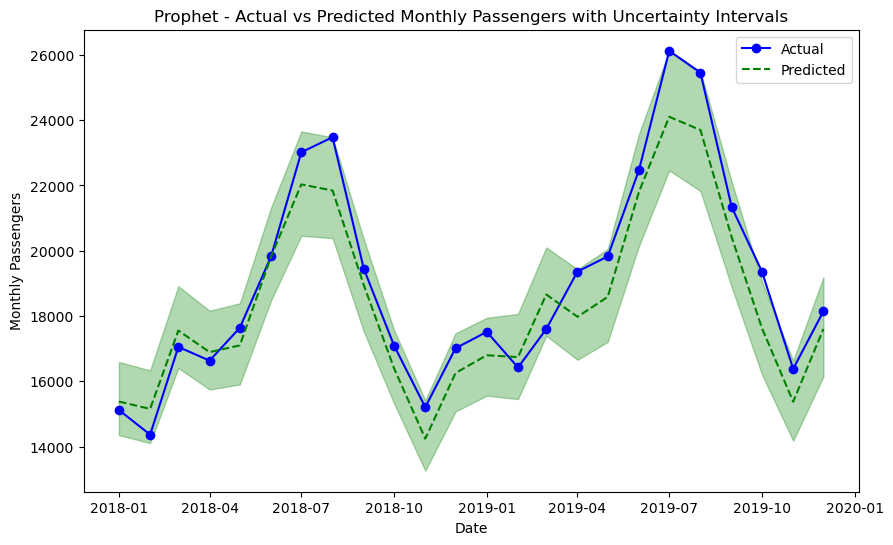

In [134]:
plt.figure(figsize=(10, 6))

plt.plot(result_df6['ds'], result_df6['y_actual'], label='Actual', color='blue', marker='o')

# Plot the predicted values from the forecast (yhat)
plt.plot(result_df6['ds'], result_df6['yhat'], label='Predicted', color='green', linestyle='--')

# Plot the uncertainty intervals (yhat_lower, yhat_upper)
plt.fill_between(result_df6['ds'], result_df6['yhat_lower'], result_df6['yhat_upper'], color='green', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Monthly Passengers')
plt.title('Prophet - Actual vs Predicted Monthly Passengers with Uncertainty Intervals')
plt.legend()
plt.show()


In [ ]:
y_true6 = test2['y'].values
y_pred6 = forecast6['yhat'][-len(test2):].values

mae6 = mean_absolute_error(y_true6, y_pred6)
rmse6 = np.sqrt(mean_squared_error(y_true6, y_pred6))
mape6 = np.mean(np.abs((y_true6 - y_pred6) / y_true6)) * 100

print(f"MAE: {mae6}")
print(f"RMSE: {rmse6}")
print(f"MAPE: {mape6}%")

MAE: 885.4171724587601
RMSE: 1023.2658220959131
MAPE: 4.537479795985319%


Model 2 demonstrated strong predictive accuracy, with improvements across all key evaluation metrics—MAE, MAPE, and RMSE. Grid search significantly improved accuracy, reducing MAPE from 6.54% to 4.54%.

# Conclusions

### Compare models SARIMA vs. Prophet

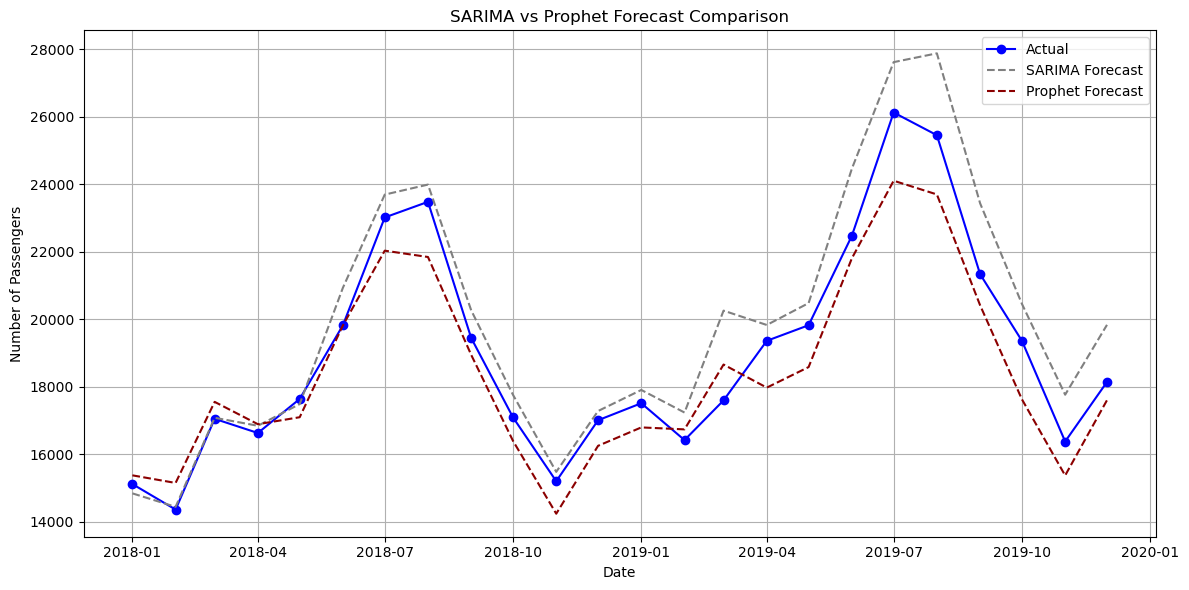

In [136]:
plt.figure(figsize=(12, 6))
# Actual values
plt.plot(df_forecast.index, df_forecast['MonthlyPassengers'], label='Actual', color='blue', marker='o')

# SARIMA forecast
plt.plot(df_forecast.index, df_forecast['Forecast'], label='SARIMA Forecast', color='grey', linestyle='--')

# Prophet forecast
plt.plot(result_df6['ds'], result_df6['yhat'], label='Prophet Forecast', color='darkred', linestyle='--')

plt.title('SARIMA vs Prophet Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SARIMA is more responsive to seasonality and fluctuations in the time series, making it better suited for data with strong cyclical trends.

Prophet offers smoother forecasts, which may be beneficial for long-term trend analysis but less suitable for capturing sharp seasonal patterns.

In [137]:
print("Model Performance Comparison:")
print("-" * 40)
print(f"{'Metric':<10} {'SARIMA':>10} {'Prophet':>10}")
print("-" * 40)
print(f"{'MAE':<10} {mae:10.2f} {mae6:10.2f}")
print(f"{'RMSE':<10} {rmse:10.2f} {rmse6:10.2f}")
print(f"{'MAPE':<10} {mape:10.2f}% {mape6:10.2f}%")
print("-" * 40)


Model Performance Comparison:
----------------------------------------
Metric         SARIMA    Prophet
----------------------------------------
MAE            927.14     885.42
RMSE          1196.16    1023.27
MAPE             4.68%       4.54%
----------------------------------------


SARIMA provides full control over trend, seasonality, and residual structure, and performs well after tuning. Initially, it struggled with higher forecasting error, but grid search significantly improved its accuracy, reducing MAPE from 10.96% to 4.68%. However, it showed a tendency to overestimate during seasonal peaks.

Prophet, on the other hand, excels in flexibility and ease of deployment. With minimal configuration, it effectively handled trend shifts and multiplicative seasonality. Its performance also improved through tuning, with MAPE dropping from 6.54% to 4.54%. While it slightly underestimated some peaks, its forecasts were generally closer to the actual values, especially in volatile periods.